## Data Exploration

In [1]:
import pandas as pd

# Load the dataset
file_path = 'adultdata.csv'
data = pd.read_csv(file_path)

file_path = 'adulttest.csv'
data2 = pd.read_csv(file_path)

data = pd.concat([data1, data2], ignore_index=True)

# Display the first few rows of the dataset to understand its structure
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Preprocessing

In [2]:
import numpy as np

# Replace ' ?' with NaN and check for missing values again
data.replace(' ?', np.nan, inplace=True)
missing_values_count = data.isnull().sum()

# Display columns with missing values
missing_values_count[missing_values_count > 0]

print(missing_values_count)

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


### Missing Values Handling 

In [3]:
# Subsitute missing values with the mode for categorical columns
for column in ['workclass', 'occupation', 'native-country']:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Check again for any remaining missing values
missing_values_count = data.isnull().sum()

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


### Data Standarization

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

# Encode and transform categorical variables of the data
categorical_columns = ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Standardize and normalized numerical features
scaler = StandardScaler()
numerical_columns = ['age','fnlwgt','education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

### Correlation Study of Variables

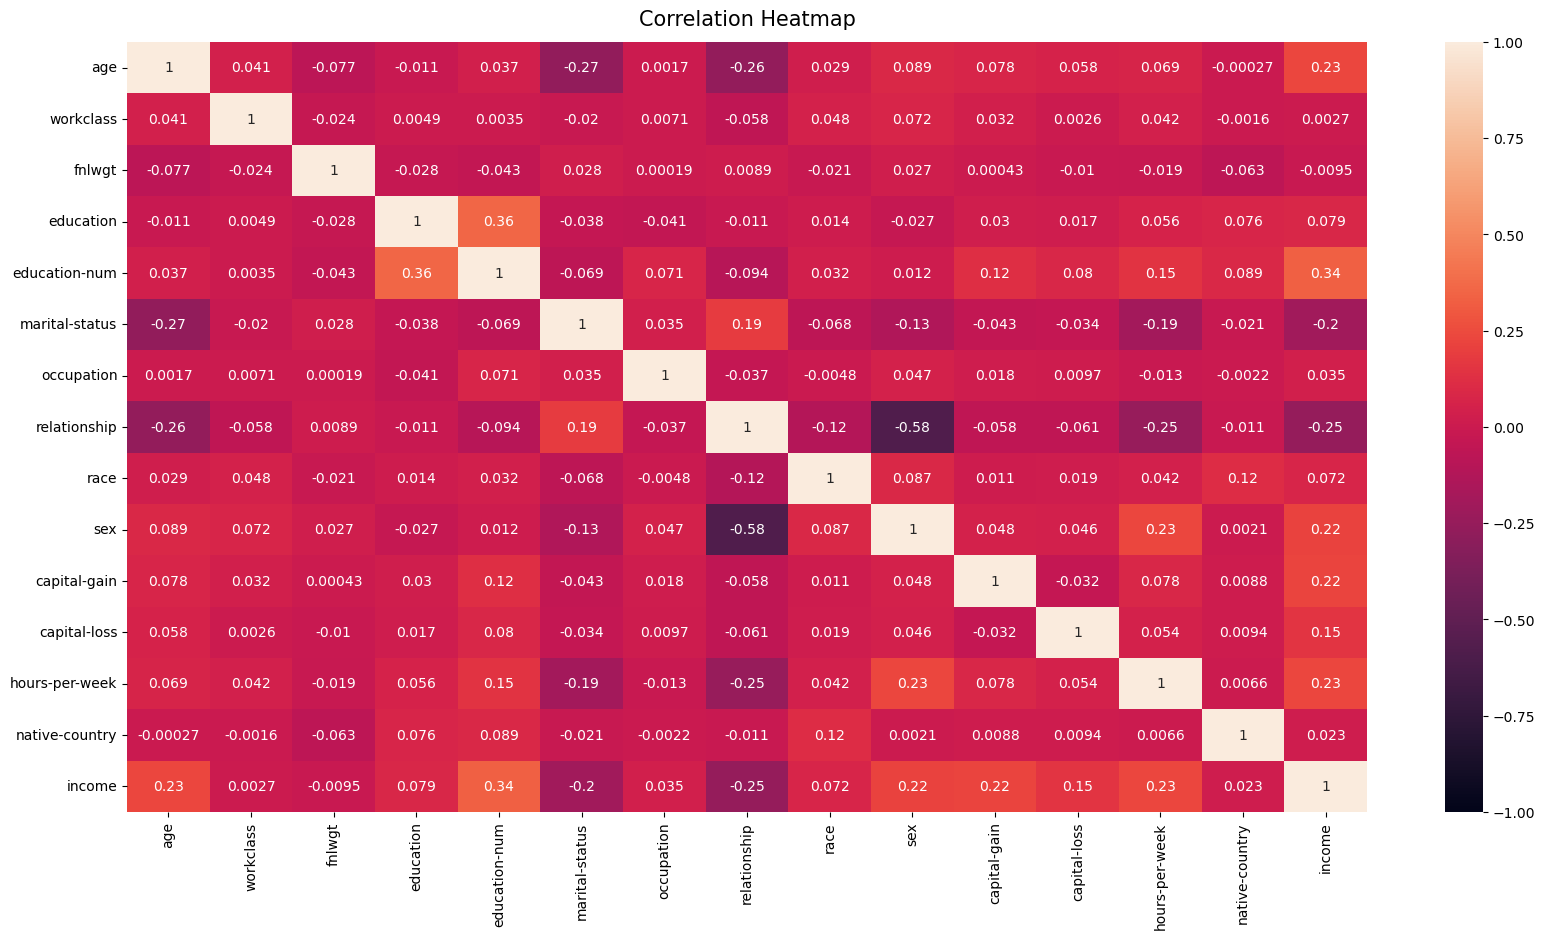

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(data.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12);

In [6]:
#Finding the best correlation with the 'income' column 
data.corr()['income'].sort_values(ascending=False)

income            1.000000
education-num     0.335154
age               0.234037
hours-per-week    0.229689
capital-gain      0.223329
sex               0.215980
capital-loss      0.150526
education         0.079317
race              0.071846
occupation        0.034625
native-country    0.023058
workclass         0.002693
fnlwgt           -0.009463
marital-status   -0.199307
relationship     -0.250918
Name: income, dtype: float64

In [7]:
#correlation study findings suggest to drop 'fnlwgt' and 'workclass' due to low correlation < 0.01
data.drop(['fnlwgt','workclass'],axis=1, inplace=True)
categorical_columns.remove('workclass')
numerical_columns.remove('fnlwgt')

### Split Training & Testing Sets

In [8]:
# Split features and target
X = data.drop('income', axis=1)
y = data['income']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# apply normalization for both training and testing set numerical columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Model Training

#### Selected Classifier:
1. Random Forest Classifier: Decision Tree-based classifier that merges predictions for better accuracy and reduced overfitting
2. Support Vector Machine (SVM) : Margin-based classifier to find optimal hyperplane to separate data points

#### Find the Best Fit Methodology:
1. Run models with default hyperparameter settings to obtain baseline performance.
2. Apply Random Search Cross Validation for both models to explore best performance parameters.
3. Apply Grid Search Cross Validation with minor hyperparamter tuning with reference to best prameters obtained from Random Cross Validation.

In [24]:
# define functions for repetitive operations

def train_model(classifier, X_train, y_train):
    start_time = time.time()             # Record the start time
    classifier.fit(X_train, y_train)     # Train the classifier
    training_time = time.time() - start_time
    
    return classifier, training_time     # Return the trained model and the training time

def evaluate_model(classifier, X_test, y_test):   
    y_pred = classifier.predict(X_test)  # Predict on test data
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') #use 'weighted' because of imbalance data 
    recall = recall_score(y_test, y_pred, average='weighted') #use 'weighted' because of imbalance data 
    f1 = f1_score(y_test, y_pred, average='weighted') #use 'weighted' because of imbalance data 
    confusion = confusion_matrix(y_test, y_pred)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": confusion
    }


### 1. Run both classifiers with default hyperparameter settings

In [25]:
# Initialize both classifiers with baseline parameters
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42)
 
# Train & Evaluate Random Forest Classifier
rf_classifier,rf_train_time = train_model(rf_classifier,X_train,y_train)
rf_metrics = evaluate_model(rf_classifier,X_test,y_test)

# Train & Evaluate SVM Classifier
svm_classifier,svm_train_time = train_model(svm_classifier,X_train,y_train)
svm_metrics = evaluate_model(svm_classifier,X_test,y_test)

# Display comparison results
comparison_results = {
    'Model': ['Random Forest', 'SVM'],
    'Training Time (s)': [rf_train_time, svm_train_time],
    'Accuracy': [rf_metrics['accuracy'], svm_metrics['accuracy']],
    'Precision': [rf_metrics['precision'], svm_metrics['precision']],
    'Recall': [rf_metrics['recall'], svm_metrics['recall']],
    'F1 Score': [rf_metrics['f1_score'], svm_metrics['f1_score']]
}

# Convert results to DataFrame for visualization
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

           Model  Training Time (s)  Accuracy  Precision    Recall  F1 Score
0  Random Forest           2.304518  0.845737   0.841434  0.845737  0.843075
1            SVM          12.116095  0.812877   0.818976  0.812877  0.771914


### 2. Random Search Cross Validation for both models to explore best performance parameters.

In [26]:
from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

######################### Random Forest #########################
# define random cross validation hyperparameter range for Random Forest 
rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 15)
}

# apply random cross validation to random forest classifier
rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Train & Evaluate Random Forest Classifier
rf_random_search,rf_train_time = train_model(rf_random_search,X_train,y_train)
rf_metrics = evaluate_model(rf_random_search,X_test,y_test)
rf_best_classifier = rf_random_search.best_estimator_

############################## SVM #################################
# define random cross validation hyperparameter range for SVM Classifier
svm_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf','linear']
}

# apply random cross validation to SVM classifier
svm_random_search = RandomizedSearchCV(SVC(random_state=42), svm_params, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Train & Evaluate SVM Classifier
svm_random_search,svm_train_time = train_model(svm_random_search,X_train,y_train)
svm_metrics = evaluate_model(svm_random_search,X_test,y_test)
svm_best_classifier = svm_random_search.best_estimator_

# Display comparison results
comparison_results = {
    'Model': ['Random Forest', 'SVM'],
    'Training Time (s)': [rf_train_time, svm_train_time],
    'Accuracy': [rf_metrics['accuracy'], svm_metrics['accuracy']],
    'Precision': [rf_metrics['precision'], svm_metrics['precision']],
    'Recall': [rf_metrics['recall'], svm_metrics['recall']],
    'F1 Score': [rf_metrics['f1_score'], svm_metrics['f1_score']]
}

# Convert results to DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string())

           Model  Training Time (s)  Accuracy  Precision    Recall  F1 Score
0  Random Forest          50.900220  0.861501   0.855769  0.861501  0.856527
1            SVM         375.302673  0.848603   0.841117  0.848603  0.841779


### 3. Grid Search Cross Validation with minor hyperparamter tuning with reference to best prameters from Random Search

In [27]:
rf_best_classifier.get_params() # get random forest best classifier parameters

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 472,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [28]:
svm_best_classifier.get_params() # get SVM best classifier parameters

{'C': 1000,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [29]:
# Run Grid Search CV Hyperparamter tuning based on previous best parameter

from scipy.stats import randint

######################### Random Forest #########################
# Hyperparameter for Random Forest Classifier 
rf_params = {
    'n_estimators': [450, 470, 490],
    'max_depth': [10, 20, 30],
    'min_samples_split': [8, 9, 10]
}

# grid search cross validation to random forest classifier
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)

# Train & Evaluate Random Forest Classifier
rf_grid_search,rf_train_time = train_model(rf_grid_search,X_train,y_train)
rf_metrics = evaluate_model(rf_grid_search,X_test,y_test)
rf_grid_best_classifier = rf_grid_search.best_estimator_

############################## SVM #################################
# Hyperparameter for SVM Classifier 
svm_params = {
    'C': [900,1000,1100],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

# grid search cross validation to SVM classifier
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_params, cv=5, scoring='accuracy', n_jobs=-1)

# Train & Evaluate SVM Classifier
svm_grid_search,svm_train_time = train_model(svm_grid_search,X_train,y_train)
svm_metrics = evaluate_model(svm_grid_search,X_test,y_test)
svm_grid_best_classifier = svm_grid_search.best_estimator_

# Display comparison results
comparison_results = {
    'Model': ['Random Forest', 'SVM'],
    'Training Time (s)': [rf_train_time, svm_train_time],
    'Accuracy': [rf_metrics['accuracy'], svm_metrics['accuracy']],
    'Precision': [rf_metrics['precision'], svm_metrics['precision']],
    'Recall': [rf_metrics['recall'], svm_metrics['recall']],
    'F1 Score': [rf_metrics['f1_score'], svm_metrics['f1_score']]
}

# Convert results to DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string())

           Model  Training Time (s)  Accuracy  Precision    Recall  F1 Score
0  Random Forest         130.280195  0.862115   0.856411  0.862115  0.857109
1            SVM          61.735597  0.848705   0.841192  0.848705  0.841775


### 4. Use best hyperparameters and fine tune models parameter to explore training time improvement (CV = 3)

In [30]:
rf_grid_best_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 450,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [31]:
svm_grid_best_classifier.get_params()

{'C': 900,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [32]:
# Run Grid Search CV Hyperparamter tuning based on previous best parameter

from scipy.stats import randint

######################### Random Forest #########################
# Hyperparameter for Random Forest Classifier 
rf_params = {
    'n_estimators': [450],
    'max_depth': [20],
    'min_samples_split': [9]
}

# grid search cross validation to random forest classifier
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy', n_jobs=-1)

# Train & Evaluate Random Forest Classifier
rf_grid_search,rf_train_time = train_model(rf_grid_search,X_train,y_train)
rf_metrics = evaluate_model(rf_grid_search,X_test,y_test)
rf_grid_best_classifier = rf_grid_search.best_estimator_

############################## SVM #################################
# Hyperparameter for SVM Classifier 
svm_params = {
    'C': [900],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

# grid search cross validation to SVM classifier
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_params, cv=3, scoring='accuracy', n_jobs=-1)

# Train & Evaluate SVM Classifier
svm_grid_search,svm_train_time = train_model(svm_grid_search,X_train,y_train)
svm_metrics = evaluate_model(svm_grid_search,X_test,y_test)
svm_grid_best_classifier = svm_grid_search.best_estimator_

# Display comparison results
comparison_results = {
    'Model': ['Random Forest', 'SVM'],
    'Training Time (s)': [rf_train_time, svm_train_time],
    'Accuracy': [rf_metrics['accuracy'], svm_metrics['accuracy']],
    'Precision': [rf_metrics['precision'], svm_metrics['precision']],
    'Recall': [rf_metrics['recall'], svm_metrics['recall']],
    'F1 Score': [rf_metrics['f1_score'], svm_metrics['f1_score']]
}

# Convert results to DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string())

           Model  Training Time (s)  Accuracy  Precision    Recall  F1 Score
0  Random Forest          16.608876  0.862115   0.856411  0.862115  0.857109
1            SVM          33.651841  0.848705   0.841192  0.848705  0.841775


### 5. Use best hyperparameters and fine tune models parameter to explore training time improvement (CV = 2)

In [34]:
# Run Grid Search CV Hyperparamter tuning based on previous best parameter

from scipy.stats import randint

######################### Random Forest #########################
# Hyperparameter for Random Forest Classifier 
rf_params = {
    'n_estimators': [450],
    'max_depth': [20],
    'min_samples_split': [9]
}

# grid search cross validation to random forest classifier
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=2, scoring='accuracy', n_jobs=-1)

# Train & Evaluate Random Forest Classifier
rf_grid_search,rf_train_time = train_model(rf_grid_search,X_train,y_train)
rf_metrics = evaluate_model(rf_grid_search,X_test,y_test)
rf_grid_best_classifier = rf_grid_search.best_estimator_

############################## SVM #################################
# Hyperparameter for SVM Classifier 
svm_params = {
    'C': [900],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

# grid search cross validation to SVM classifier
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_params, cv=2, scoring='accuracy', n_jobs=-1)

# Train & Evaluate SVM Classifier
svm_grid_search,svm_train_time = train_model(svm_grid_search,X_train,y_train)
svm_metrics = evaluate_model(svm_grid_search,X_test,y_test)
svm_grid_best_classifier = svm_grid_search.best_estimator_

# Display comparison results
comparison_results = {
    'Model': ['Random Forest', 'SVM'],
    'Training Time (s)': [rf_train_time, svm_train_time],
    'Accuracy': [rf_metrics['accuracy'], svm_metrics['accuracy']],
    'Precision': [rf_metrics['precision'], svm_metrics['precision']],
    'Recall': [rf_metrics['recall'], svm_metrics['recall']],
    'F1 Score': [rf_metrics['f1_score'], svm_metrics['f1_score']]
}

# Convert results to DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string())

           Model  Training Time (s)  Accuracy  Precision    Recall  F1 Score
0  Random Forest          14.296239  0.862115   0.856411  0.862115  0.857109
1            SVM          29.281990  0.848705   0.841192  0.848705  0.841775


### 6. Use best hyperparameters and fine tune models parameter to explore training time improvement (CV = 2, remove scoring)

In [35]:
# Run Grid Search CV Hyperparamter tuning based on previous best parameter

from scipy.stats import randint

######################### Random Forest #########################
# Hyperparameter for Random Forest Classifier 
rf_params = {
    'n_estimators': [450],
    'max_depth': [20],
    'min_samples_split': [9]
}

# grid search cross validation to random forest classifier
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=2, n_jobs=-1)

# Train & Evaluate Random Forest Classifier
rf_grid_search,rf_train_time = train_model(rf_grid_search,X_train,y_train)
rf_metrics = evaluate_model(rf_grid_search,X_test,y_test)
rf_grid_best_classifier = rf_grid_search.best_estimator_

############################## SVM #################################
# Hyperparameter for SVM Classifier 
svm_params = {
    'C': [900],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

# grid search cross validation to SVM classifier
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_params, cv=2, n_jobs=-1)

# Train & Evaluate SVM Classifier
svm_grid_search,svm_train_time = train_model(svm_grid_search,X_train,y_train)
svm_metrics = evaluate_model(svm_grid_search,X_test,y_test)
svm_grid_best_classifier = svm_grid_search.best_estimator_

# Display comparison results
comparison_results = {
    'Model': ['Random Forest', 'SVM'],
    'Training Time (s)': [rf_train_time, svm_train_time],
    'Accuracy': [rf_metrics['accuracy'], svm_metrics['accuracy']],
    'Precision': [rf_metrics['precision'], svm_metrics['precision']],
    'Recall': [rf_metrics['recall'], svm_metrics['recall']],
    'F1 Score': [rf_metrics['f1_score'], svm_metrics['f1_score']]
}

# Convert results to DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string())

           Model  Training Time (s)  Accuracy  Precision    Recall  F1 Score
0  Random Forest          13.824766  0.862115   0.856411  0.862115  0.857109
1            SVM          27.927725  0.848705   0.841192  0.848705  0.841775


# Feature Importance Study

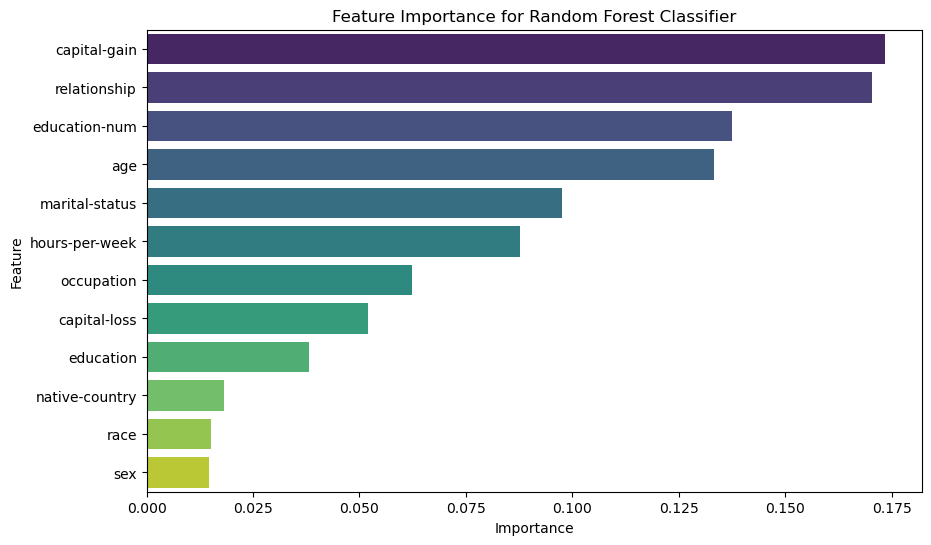

In [36]:
# Plot feature importance for Random Forest
importances = rf_best_classifier.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance for Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

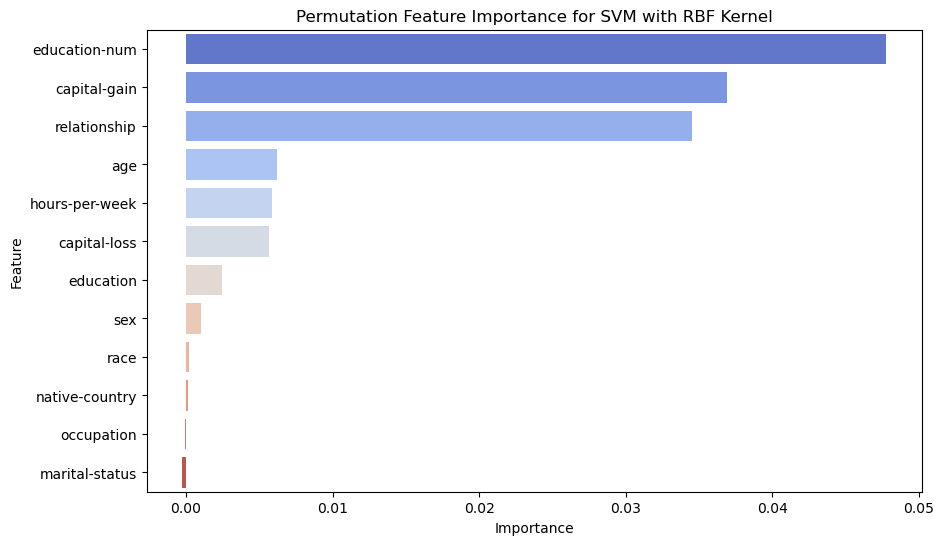

In [37]:
from sklearn.inspection import permutation_importance

# Plot feature importance for SVM using Permutation Importance (for non-linear kernels like 'rbf')
if svm_best_classifier.kernel == 'rbf':
    perm_importance = permutation_importance(svm_best_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})
    perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='coolwarm')
    plt.title('Permutation Feature Importance for SVM with RBF Kernel')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [39]:
import shap as SH
SH.initjs()

TreeExp = SH.TreeExplainer(rf_grid_best_classifier)
shap_values = TreeExp.shap_values(X_test.iloc[[20]])
SH.force_plot(TreeExp.expected_value[0], shap_values[0], X_test.iloc[[20]])